# RUN WITH PYTHON 3.11.5!!!!

In [1]:
import PyPDF2
import re
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from gensim.models.tfidfmodel import TfidfModel
from gensim.corpora.dictionary import Dictionary

In [2]:
def extract_text_from_pdf(pdf_path) :
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ''
        for page_num in range(len(reader.pages)):
            text += reader.pages[page_num].extract_text()
    return text

In [3]:
harry_potter = extract_text_from_pdf('HarryPotterylaPiedraFilosofal.pdf')

In [4]:
#Using Regular Expressions to Extract Names (This can be more efficient with Named Entity Recognition)
match_capitlized_words = '[A-Z]\w+'
capitalized_words = re.findall(match_capitlized_words, harry_potter)

In [19]:
#Creating a dataframe with the most common capitalized words
#Also excluding stop words manually
df = pd.DataFrame(capitalized_words)
dfCounts = df.value_counts()
dfCounts = dfCounts.reset_index()
dfCounts = dfCounts.rename(columns={0:'Name'})
dfCounts = dfCounts[-dfCounts['Name'].isin(['No','El','La','Se','Pero','Los','Qué'])]
dfCounts = dfCounts[dfCounts['count']>=100]

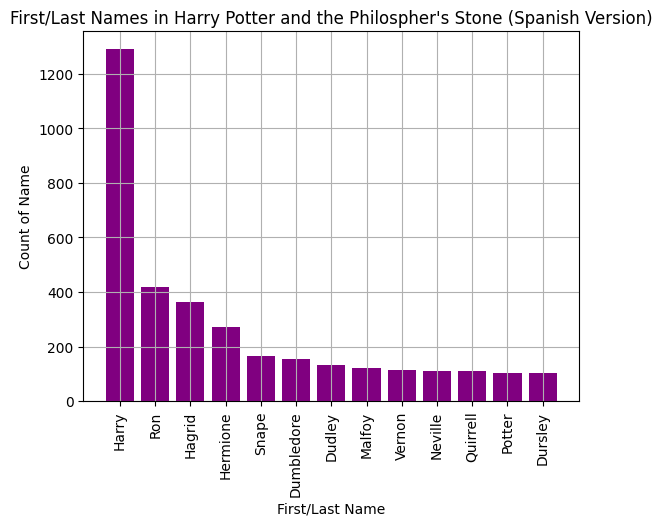

In [15]:
#Creting a common names barplot
plt.bar(dfCounts['Name'], dfCounts['count'], color = 'purple')
plt.xticks(rotation = 90)
plt.ylabel('Count of Name')
plt.xlabel('First/Last Name')
plt.title("First/Last Names in Harry Potter and the Philospher's Stone (Spanish Version)")
plt.grid()
plt.savefig('frequent-names.png',dpi=300, bbox_inches='tight')
plt.show()

In [50]:
#Splitting the document into chapters and getting metadata from the chapters
chapters = re.split('CAPÍTULO', harry_potter)[1:]
chapter_metadata = pd.DataFrame()
chapter_metadata['Character Length'] = pd.DataFrame([len(chapter) for chapter in chapters])
chapter_metadata.index+=1
#Tokenizing each chapter
chapter_tokens = [word_tokenize(chapter) for chapter in chapters]
chapter_tokens = [[word.lower() for word in token if word.isalpha()] for token in chapter_tokens]
chapter_metadata['Number of Words'] = [len(token) for token in chapter_tokens]

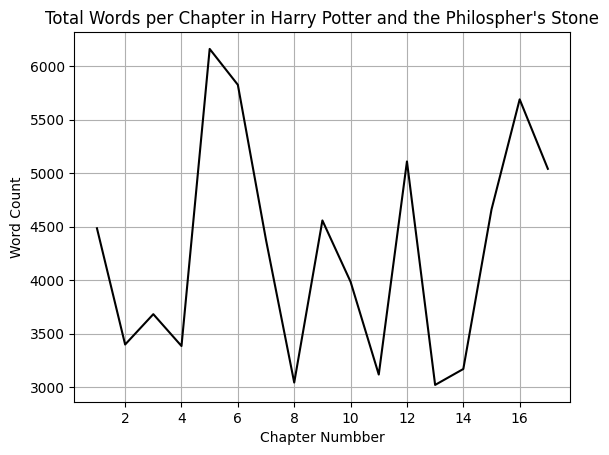

In [28]:
#Creating a word count plot
plt.plot(chapter_metadata['Number of Words'], color = 'black')
plt.ylabel('Word Count')
plt.xlabel('Chapter Numbber')
plt.title("Total Words per Chapter in Harry Potter and the Philospher's Stone")
plt.grid()
plt.savefig('word-count.png',dpi=300, bbox_inches='tight')
plt.show()

In [51]:
#Removing stop-words
chapter_tokens = [[word for word in  words if word not in stopwords.words('spanish')] for words in chapter_tokens]

In [52]:
#Checking the top 10 words from chapter 7
chapter_number = 7
Counter(chapter_tokens[chapter_number-1]).most_common(10)

[('harry', 58),
 ('sombrero', 34),
 ('percy', 17),
 ('mientras', 15),
 ('año', 14),
 ('profesora', 14),
 ('slytherin', 14),
 ('vez', 13),
 ('si', 13),
 ('tan', 12)]

In [53]:
#Getting the top 15 words for each chapter according to the tfidf model
dictionary = Dictionary(chapter_tokens)
corpus = [dictionary.doc2bow(chapter) for chapter in chapter_tokens]
tfidf = TfidfModel(corpus)
chapter_topics = []
i = 1
for chapter_corpus in corpus :
    tfidf_weights = tfidf[chapter_corpus]
    tfidf_weights.sort(key = lambda x : x[1], reverse = True)
    top_words = tfidf_weights[:15]
    topic_words = [dictionary.get(word[0]) for word in top_words]
    chapter_topics.append(topic_words)
    print(f"Topic words in chapter {i}:{topic_words}")
    i+=1

Topic words in chapter 1:['gato', 'dursley', 'niño', 'calle', 'taladros', 'mantas', 'moto', 'esquina', 'drive', 'privet', 'profesora', 'señor', 'hermana', 'hijo', 'número']
Topic words in chapter 2:['piers', 'dudley', 'vidrio', 'vernon', 'tía', 'petunia', 'serpiente', 'menudo', 'alacena', 'cocina', 'tío', 'figg', 'zoológico', 'coche', 'bicicleta']
Topic words in chapter 3:['vernon', 'tío', 'dudley', 'cartas', 'petunia', 'bastón', 'tía', 'alacena', 'smeltings', 'carta', 'cocina', 'uniforme', 'buzón', 'factura', 'hotel']
Topic words in chapter 4:['vernon', 'tío', 'irá', 'sofá', 'paraguas', 'lily', 'gigante', 'mago', 'misterio', 'salchichas', 'dudley', 'madre', 'acabó', 'despectiva', 'galopantes']
Topic words in chapter 5:['ollivander', 'griphook', 'tienda', 'monedas', 'tiendas', 'hagrid', 'duende', 'fénix', 'chorreante', 'centímetros', 'madame', 'malkin', 'caldero', 'galeones', 'mostrador']
Topic words in chapter 6:['andén', 'ron', 'carrito', 'compartimiento', 'tren', 'ventanilla', 'nuev

In [57]:
#Creating a Pandas dataframe with the results
chapter_topics_df = pd.DataFrame(chapter_topics)
chapter_topics_df = chapter_topics_df.rename(columns={i : f'Word {i + 1}' for i in range(chapter_topics_df.shape[1])})
chapter_topics_df['Chapter number'] = [f'Chapter {i+1}' for i in range(chapter_topics_df.shape[0])]
chapter_topics_df = chapter_topics_df.set_index('Chapter number')
chapter_topics_df.to_csv("Topic Words Harry Potter and the Philospher's Stone.csv")